### Downloading the data

In [19]:
from main import main
key = '<replace with your key>' # this is the key for the weather data API

In [20]:
# uncomment this line on your own risk
# it will take ~15-20 minutes to download the data and to do some cleaning
#main(key)

In [21]:
from configs import merged_cycle_data_file
import pandas as pd
from sklearn.model_selection import train_test_split

### Load the weather & holiday data

In [22]:
from configs import weather_data_csv

holidays = 'holidays.csv'
hol_df = pd.read_csv(holidays, index_col='date', parse_dates=['date'])
weather_df = pd.read_csv(weather_data_csv, index_col='timestamp', parse_dates=['timestamp'])
weather_df.head()

,temperature,feelsLike,wind,weatherCode
timestamp,,,,
2015-01-01 00:00:00,3,-2,21,116
2015-01-01 01:00:00,3,-2,21,116
2015-01-01 02:00:00,3,-1,20,116
2015-01-01 03:00:00,3,-1,20,116
2015-01-01 04:00:00,4,0,20,116


In [23]:
# get a set of the holiday dates
hol_set= set(hol_df.index.map(lambda x: x.date()))

### Load the merged csv file by reading it in chunks

# Warning:
The next cell takes a lot of time (on one machine it took 3h 40 mins) so skip running this cell.

In [24]:
# %%time
# from datetime import datetime
# import time
# chunk_size = 1000000
# date_mapper = lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=x.day, hour=x.hour))

# bike_share_df = pd.DataFrame()
# print('Started loading merged_cycle_data_file.')
# iter_ = pd.read_csv(merged_cycle_data_file, chunksize=chunk_size, iterator=True,
#         index_col='Rental Id',
#         parse_dates=['End Date', 'Start Date'])
# print('Finished loading merged_cycle_data_file.')

# r_start = time.time()
# for i, df in enumerate(iter_):
#     r_end = time.time()
#     print(f'{i+1}. Read rows {chunk_size*i}:{chunk_size*(i+1)} in {r_end-r.start:.3f}. ', end='')

#     start = time.time()
#     df = df.dropna()
#     # leave only entries that have valid duration
#     df = df[df['Duration'] > 0]
    
#     diff = df['End Date'] - df['Start Date'] # compute the difference between the objects
#     seconds = diff.map(lambda x: x.total_seconds()) # map to seconds
#     df = df[(df['Duration'] == seconds) & (seconds >= 0)] # check if duration matches the result and if the result is positive
    
    
#     # keep only year, month, day, hour information from the start date
#     df['Start Date'] = df['Start Date'].map(date_mapper)
    
#     share_df = df.groupby('Start Date').agg({'Start Date': 'count'}).rename(columns={'Start Date': 'share_count'})
#     share_df = share_df.join(weather_df)
#     share_df = share_df.reset_index()
#     share_df = share_df.dropna()
    
#     share_df['month'] = share_df['Start Date'].apply(lambda t: t.month)
#     share_df['weekday'] = share_df['Start Date'].apply(lambda t: t.weekday())
#     share_df['hour'] = share_df['Start Date'].apply(lambda t: t.hour)
#     share_df['is_holiday'] = share_df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')
#     # check if start date hits on a weekend
#     # monday is 0, sunday is 6
#     share_df['is_weekend'] = share_df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')
#     share_df['weatherCode'] = share_df['weatherCode'].map(lambda x: str(int(x)))
    
#     bike_share_df = bike_share_df.append(share_df)
#     end = time.time()
#     print(f'Completed cleaning & merging in {end-start:3.3f} seconds.')
#     r_start = time.time()

# print('Finished reading!')
# bike_share_df = bike_share_df.reset_index().drop(columns=['index']) # fix the index
# # save the data to a file, so that we can load it faster next time
# bike_share_df.to_csv('shares-ungrouped.csv')

In [25]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str
}
bike_share_df = pd.read_csv('shares-ungrouped.csv', parse_dates=['Start Date'], dtype=types).drop(columns=['Unnamed: 0'])

In [26]:
bike_share_df.shape

(42768, 11)

In [27]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42768 entries, 0 to 42767
Data columns (total 11 columns):
Start Date     42768 non-null datetime64[ns]
share_count    42768 non-null int64
temperature    42768 non-null float64
feelsLike      42768 non-null float64
wind           42768 non-null float64
weatherCode    42768 non-null object
month          42768 non-null int64
weekday        42768 non-null int64
hour           42768 non-null int64
is_holiday     42768 non-null object
is_weekend     42768 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 3.6+ MB


In [28]:
bike_share_df.head()

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2016-01-02 00:00:00,129,8.0,4.0,36.0,122,1,5,0,0,1
1,2016-01-02 01:00:00,61,8.0,4.0,35.0,122,1,5,1,0,1
2,2016-01-02 02:00:00,35,9.0,5.0,33.0,122,1,5,2,0,1
3,2016-01-02 03:00:00,31,9.0,5.0,32.0,122,1,5,3,0,1
4,2016-01-02 04:00:00,33,9.0,5.0,31.0,122,1,5,4,0,1


In [29]:
# because of reading in chunks, some hours appear multiple times
bike_share_df[bike_share_df['Start Date'] == '2018-12-07 10:00:00']

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
8115,2018-12-07 10:00:00,996,12.0,10.0,27.0,296,12,4,10,0,0
8959,2018-12-07 10:00:00,292,12.0,10.0,27.0,296,12,4,10,0,0


In [30]:
share_total = bike_share_df.groupby('Start Date').agg({'share_count': 'sum'})
share_row = bike_share_df.groupby('Start Date').agg(lambda x: x.iloc[0])
share_row['share_count'] = share_total['share_count']
bike_share_df = share_row.reset_index()
bike_share_df.to_csv('shares-grouped.csv', index=False)

In [31]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38757 entries, 0 to 38756
Data columns (total 11 columns):
Start Date     38757 non-null datetime64[ns]
share_count    38757 non-null int64
temperature    38757 non-null float64
feelsLike      38757 non-null float64
wind           38757 non-null float64
weatherCode    38757 non-null object
month          38757 non-null int64
weekday        38757 non-null int64
hour           38757 non-null int64
is_holiday     38757 non-null object
is_weekend     38757 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 3.3+ MB


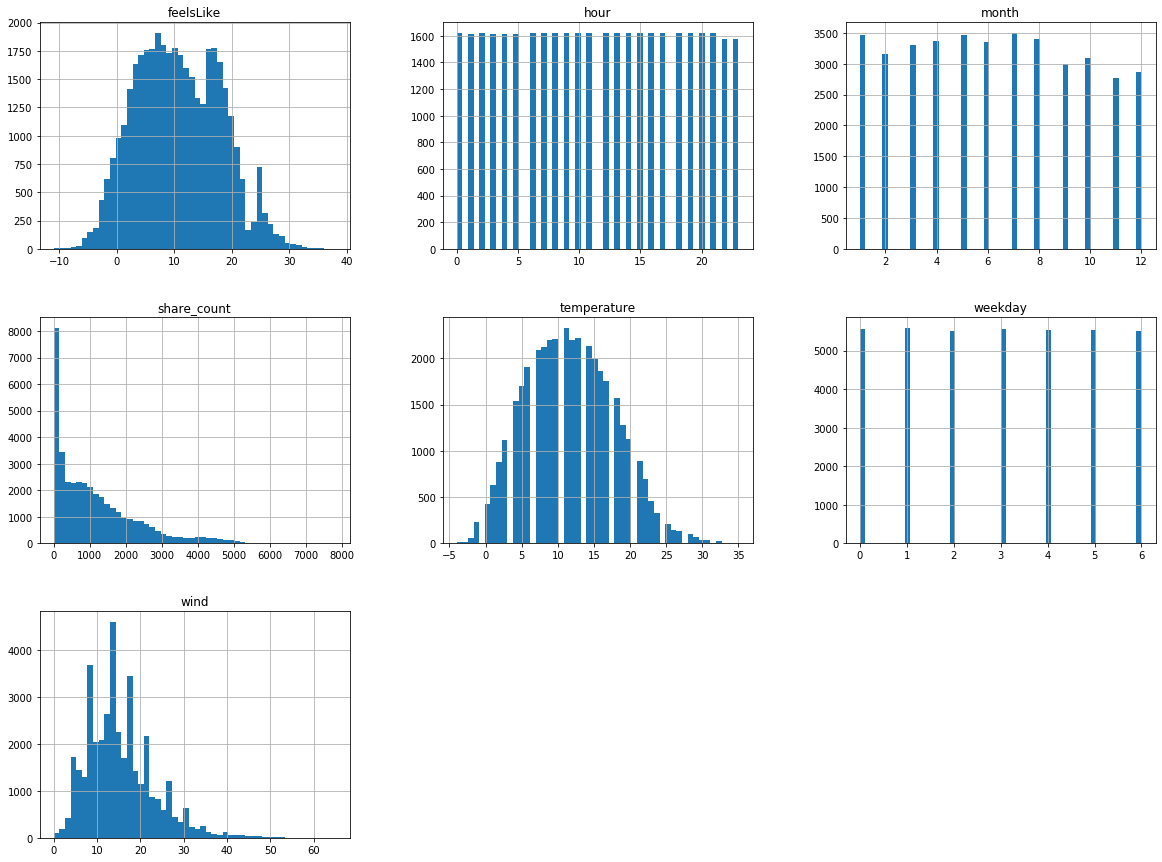

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
bike_share_df.hist(bins=50, figsize=(20,15))
plt.show()

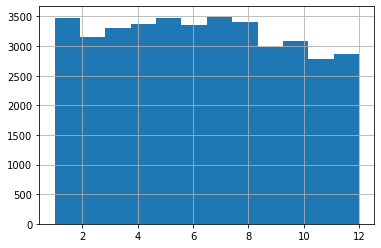

In [33]:
bike_share_df['month'].hist(bins=12)

In [34]:
bike_share_df['weatherCode'].value_counts()

113    10191
116    10159
122     7931
119     4893
176     1393
143     1191
353      730
266      546
296      456
248      319
302      270
200      132
263       84
299       60
317       57
356       48
338       45
332       36
308       35
293       33
389       25
230       24
326       21
371       18
329        9
386        9
227        9
320        6
362        6
323        6
359        6
368        3
305        3
335        3
Name: weatherCode, dtype: int64

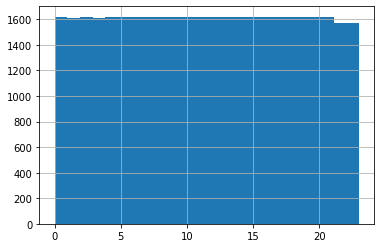

In [35]:
bike_share_df['hour'].hist(bins=24)

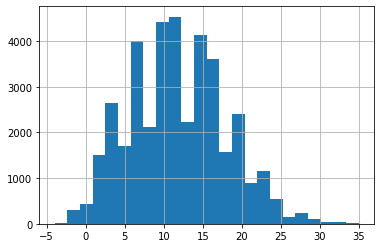

In [36]:
bike_share_df['temperature'].hist(bins=24)

In [37]:
bike_share_df[bike_share_df['share_count'] <= 100].shape

(5563, 11)

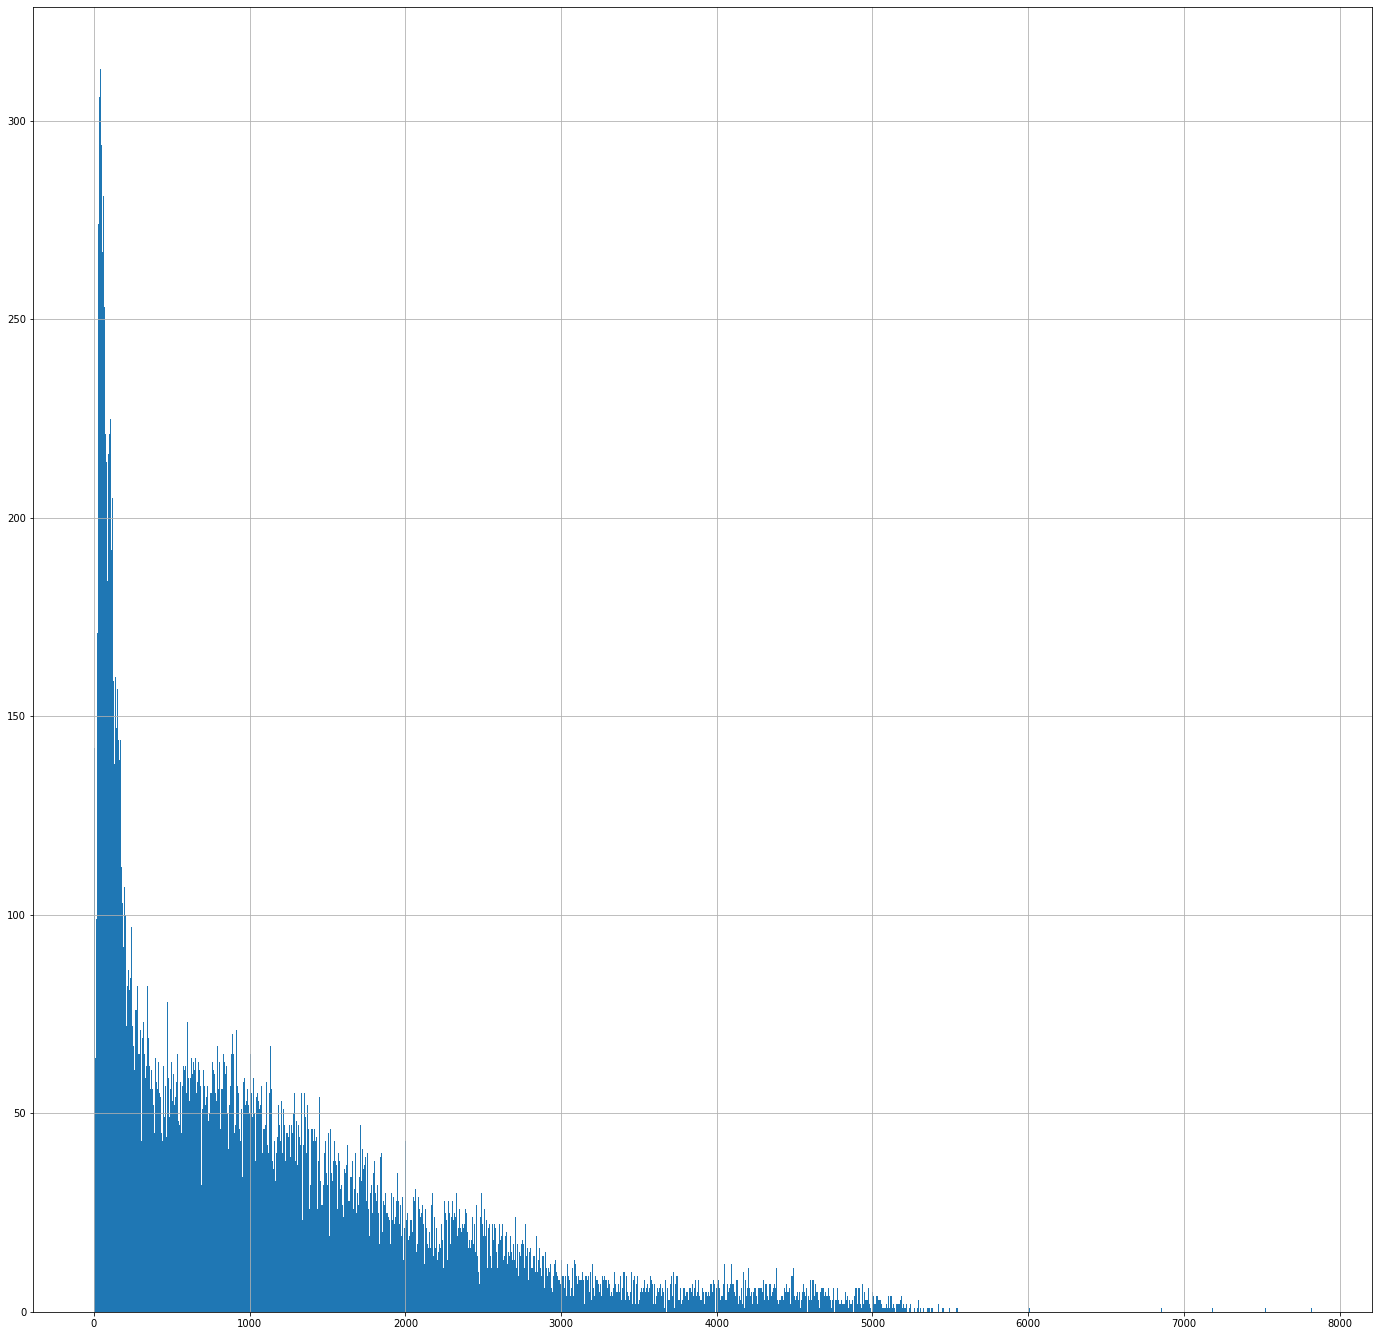

In [38]:
bike_share_df['share_count'].hist(bins=2000, figsize=(24,24))

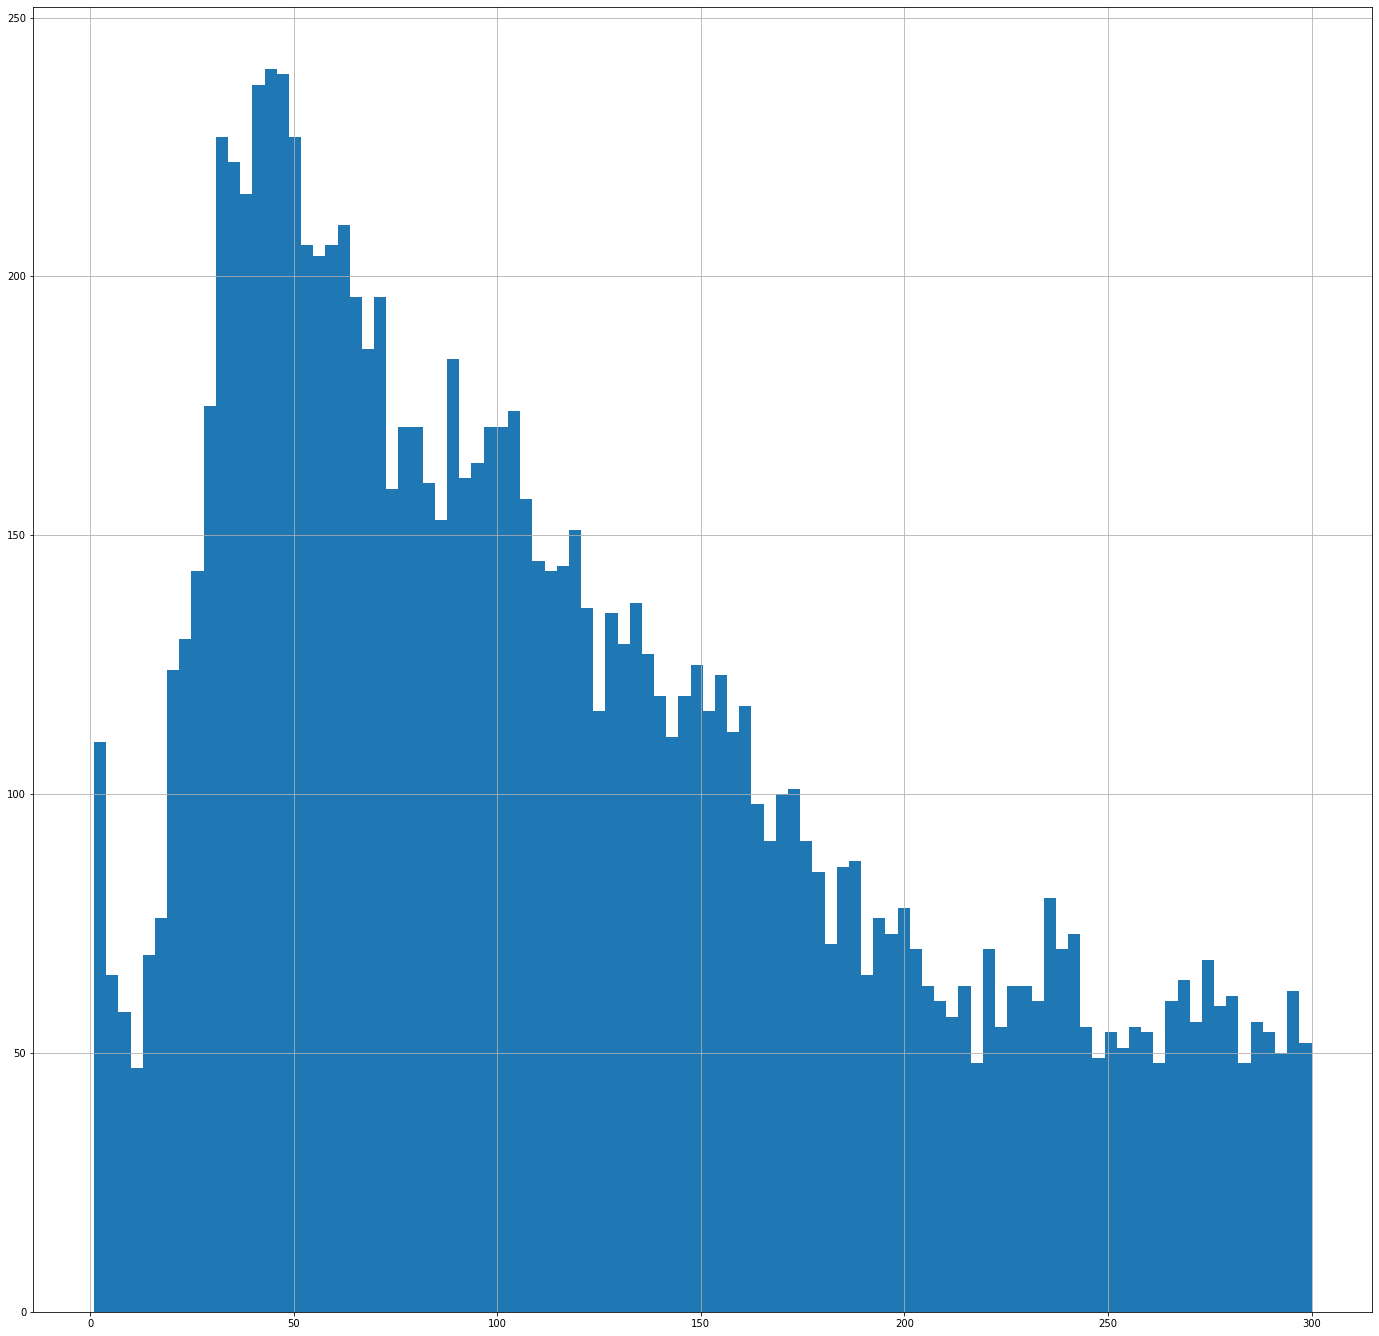

In [39]:
bike_share_df[bike_share_df['share_count'] <= 300]['share_count'].hist(bins=100, figsize=(24,24))

In [40]:
# LabelBinarizer can apply the transformation from text categories
# to integer categories, then from integer categories to one-hot vectors
# basically, it combines a label encoder with one-hot encoder
# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# holiday_cat = bike_share_df['weatherCode']
# holiday_cat_1hot = encoder.fit_transform(holiday_cat.to_numpy())
# holiday_cat_1hot

In [ ]:
encoded_weather_codes = pd.get_dummies(bike_share_df['weatherCode'], prefix='weather')
bike_share_df = bike_share_df.drop(['weatherCode'], axis=1)
bike_share_df = bike_share_df.join(encoded_weather_codes)
encoded_weather_codes